In [1]:
%%capture --no-stderr
!pip install yfinance
!pip install itertools
!pip install statsmodels
!pip install botorch
!pip install torchsummary

In [2]:
import pandas as pd
import yfinance as yf
from itertools import combinations
from statsmodels.tsa.stattools import coint, adfuller
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
import os
import math
import torch
import random
import numpy as np
import torch.nn as nn
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_mll
from botorch.acquisition import ExpectedImprovement, qExpectedImprovement, UpperConfidenceBound
from botorch.acquisition.knowledge_gradient import qKnowledgeGradient
from botorch.optim import optimize_acqf
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from torchsummary import summary

from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore')

# Pairs trading strategy

Pairs trading is a market-neutral strategy that generates potential profits regardless of the overall market direction. The “pair” in pairs trading refers to simultaneously taking two positions: going long on one asset and short on another, with the key requirement being that these assets are highly correlated. The trading signal stems from the spread or price difference between these two assets. An unusually large spread, in comparison to historical data, suggests a temporary divergence, and the anticipation is that this divergence will eventually correct itself, reverting to its mean over time. 

Pairs trading strategy is a statistical strategy, which means that it refers to hypothesis testing, which is a suite of statistical procedures that allows us to determine if a specific relationship among multiple financial instruments based on the observed data is statistically significant. It relies on mean reversion, which assumes that financial instruments that have deviated far from their historical relationship will eventually converge again. 

In [3]:
stocks = ['GOOG', 'MSFT', 'AAPL', 'TSLA', 'META', 'NFLX', 'NVDA', 'AMZN', 'BABA', 'INTC', 'PYPL', 'GM', 'PIO', 'C', 'SUP', 'DIS', 'XLI', 'COKE', 'ELP', 'VZ', 'CPK', 'WCN', 'F', 'WOOD']
start_date_trading="2022-01-01"
end_date_trading="2023-12-31"

df = yf.download(stocks, start=start_date_trading, end=end_date_trading)['Adj Close']

[*********************100%%**********************]  24 of 24 completed


The cointegration test is a test realized to see whether two stocks are enough correlated for applying a pairs strategy. We use the Engle-Granger method:
* Estimate the coefficients of the linear regression model between othe two stocks using ordinary least squares (OLS): $Y = \alpha + \beta X + \varepsilon$
* Calculate the residuals from the linear regression model
* Test the residuals for stationarity using a unit root test, such as the augmented Dickey-Fuller (ADF) test. If the p-value from this test is less than 5%, we can say that the input serie is stationary (up to a confidence of 95%).

If the residuals are stationary, the two stocks are cointegrated. If the residuals are non-stationary, the two stocks are not cointegrated.

Correlation quantifies the degree of linear association between two time series, it reveals whether the two variables increase or decrease in tandem and the strength of this relationship. In contrast, cointegration is concerned with the long-term equilibrium relationship between two potentially non-stationary time series. If two time series are cointegrated, it signifies that they share a common long-term trend, regardless of their short-term variations. This enables analysts to uncover persistent relationships masked by transitory
market volatility.

In [4]:
def coint_custom(X, Y):
    X_with_constant= sm.add_constant(X) #we add a constant of ones to be able to catch the alpha parameter of the linear regression
    model = OLS(Y, X_with_constant).fit()
    epsilon = Y - model.predict()
    return adfuller(epsilon)

In [5]:
stock_pairs = list(combinations(df.columns,2)) #list of all stock pairs
pvalues=[]
pvalues_custom=[]

# run Engle-Granger test for cointegration on each pair of stocks
for stock1, stock2 in stock_pairs:
    score, pvalue, _ = coint(df[stock1], df[stock2])
    score_custom, pvalue_custom, _, _, _,_ = coint_custom(df[stock1], df[stock2])
    pvalues.append(pvalue)
    pvalues_custom.append(pvalue_custom)

In [6]:
threshold = 0.02
coint_stocks=[] #this will be the list of cointegrated pairs of stocks

for i in range(len(pvalues)):
 # check if the current pair of stocks is cointegrated
 if pvalues[i] < threshold:
    coint_stocks.append(stock_pairs[i])
#coint_stocks

In [7]:
stock1, stock2=stock_pairs[np.array(pvalues).argmin()]
stock1, stock2= ('MSFT', 'NVDA')

For each pair of cointegrated stock, we calculate the residuals of the linear regression between the two stocks. These are the spreads between the two stocks, that are unexplained by the other stock. As the stocks are cointegrated, the spread is a white noise. \
Then, we standardize the spread using Z-score: $z=\frac{X-\mu}{\sigma}$. It allows us to have a comparable number between stock that have different means and standard deviations. The magnitude of the z-score indicates how far away the current observation deviates from the mean in terms of the unit of standard deviations, and the sign of the z-score suggests whether the deviation is above (a positive z-score) or below (a negative z-score) the mean. \
This z-score will be used as a trading signal. When it crosses a threshold, it means that the stocks are more away from each other than usual and that we could take profit of this. For example, if the z-score is below -2, it means that the spread is more negative than usual and that it may evert back to its mean. In this case, it is interesting to long stock 1 and short stock 2, because if the spread is unusually low, it means that stock 2 is unusually high. When the spread comes back to a more usual value (let's say the z-score is above -1), we can close our position.

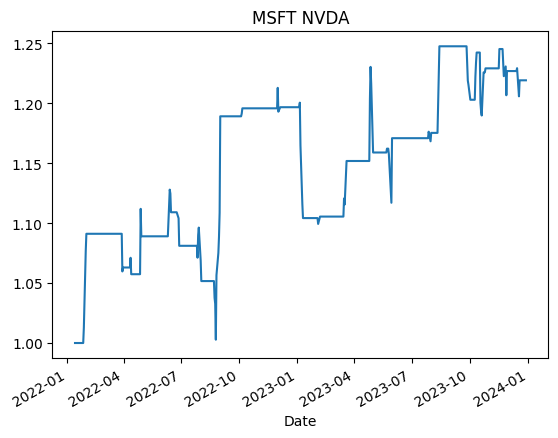

Sharpe ratio:  0.45


In [8]:
def sharpe_ratio(df, stock1, stock2, entry_threshold=2, exit_threshold=1, riskfree_rate=.04, plot_cum_returns=True, test_X=None):
    Y = df[stock1]
    X = df[stock2]
    X_with_constant = sm.add_constant(X)
    model_ols = OLS(Y, X_with_constant).fit() # estimate linear regression coefficients
    spread = Y - model_ols.predict() # get the residuals

    # convert to z score
    # derive a running mean and standard deviation by using a moving window
    window_size = 10
    spread_pred = spread.rolling(window=window_size)
    zscore = (spread - spread_pred.mean()) / spread_pred.std()

    # the use of a rolling window makes the first window_size-1 number unusable so we only keep the valid numbers
    first_valid_idx = zscore.first_valid_index()
    zscore = zscore[first_valid_idx:]
    #zscore.plot(figsize=(12,6))

    # initialize the daily positions to be zeros
    stock1_position = pd.Series(data=0, index=zscore.index)
    stock2_position = pd.Series(data=0, index=zscore.index)
    for i in range(1, len(zscore)): # for each day, set up the positions
        if zscore.iloc[i] < -entry_threshold and stock1_position.iloc[i-1] == 0: # if zscore<-2 and no existing long position for stock 1, enter the positions:
            stock1_position.iloc[i] = 1 # long stock 1
            stock2_position.iloc[i] = -1 # short stock 2
        elif zscore.iloc[i] > entry_threshold and stock2_position.iloc[i-1] == 0: # if zscore>2 and no existing short position for stock 2, enter the positions:
            stock1_position.iloc[i] = -1 # short stock 1
            stock2_position.iloc[i] = 1 # long stock 2
        elif abs(zscore.iloc[i]) < exit_threshold: # if -1<zscore<1, close the positions
            stock1_position.iloc[i] = 0
            stock2_position.iloc[i] = 0
        else: # if -2<zscore<-1 or 1<zscore<2, maintain positions
            stock1_position.iloc[i] = stock1_position.iloc[i-1]
            stock2_position.iloc[i] = stock2_position.iloc[i-1]

    # Calculate returns for each stock
    stock1_returns = (Y[first_valid_idx:].pct_change() * stock1_position.shift(1)).fillna(0) # we use shift method because return is calculated using the position at the end of the previous day
    stock2_returns = (X[first_valid_idx:].pct_change() * stock2_position.shift(1)).fillna(0)
    # calculate the total returns of the strategy
    total_returns = stock1_returns + stock2_returns
    if plot_cum_returns:
        cumulative_returns = (1 + total_returns).cumprod()
        # plot the cumulative returns
        cumulative_returns.plot(title=stock1+" "+stock2)
        plt.show()
    
    annualized_return = (1 + total_returns).prod()** (252/Y[first_valid_idx:].shape[0])-1
    # calculate annualized volatility
    annualized_vol = total_returns.std()*(252**0.5)
    if annualized_vol==0:
        annualized_vol = 100
    # calculate Sharpe ratio
    sharpe_ratio = (annualized_return - riskfree_rate) / annualized_vol
    return sharpe_ratio

#for stock1, stock2 in coint_stocks:
#    print(sharpe_ratio(stock1, stock2))
print("Sharpe ratio: ", round(sharpe_ratio(df, stock1, stock2),2))

# Optimization
As the results are not very satisfying, we will try to enhance our algorithm. For that, we are going to use Bayesian Optimization.
We look for the optimal set of parameters, that is the one that will give us the highest profit, for multiple backtesting periods to be sure that it performs well on various market conditions. Manually choosing parameters or using grid search may be too time-consuming or computationally expensive so optimization techniques are useful because they efficiently set a new set of parameter depending on previous results. We set up an objective function whose we search for a global maximum. This function is a black-box function, ie we only can evaluate it for some inputs but we have no knowledge of its mathematical form or any derivative information. There is a trade-off to find between exploration of new areas and exploitation of promising results. There are algorithms to avoid being stuck in a local optimum. The search domain shoud be a bounded, compact and convex set. One of the advantage of Bayesian optimization compared with other gradient-based optimization is that it is less likely to converge to a local optimum. Bayesian optimization uses a probabilistic model to represent the unknown function and a utility function (also called the acquisition function) to decide where to sample next. It iteratively updates the probabilistic model with new sample points and uses this updated model to select the next sampling location. It iteratively updates the probabilistic model with new sample points and uses this updated model to select the next sampling location. The objective function is often noise-corrupted (due to the choice of the backtesting period) making the optimization more difficult. Bayesian optimization achieves the exploration-exploitation trade-off via two components: a Gaussian process (GP) used to approximate the underlying black-box function and an acquisition function that encodes the exploration-exploitation trade-off into a scalar value as an indicator of the sampling utility across all candidates in the domain.

* GP: each point of the objective function is a random variable normally distributed. If we sample many points, this will create a sample of the black-box function. Between two evaluated points (where we are sure of the objective value if we assume a noise-free and exact observation model), we can create a 95% area where we are sure at 95% that the objective value is in this area. 
* Acquisition function: the posterior predictive distribution obtained from the updated Gaussian process provides an outlook on the objective value and the associated uncertainty for locations not explored yet, which could be used by the optimization policy to quantify
the utility of any alternative location within the domain. An acquisition function is a manually designed mechanism that evaluates the relative potential of each candidate location in the form of a scalar score, and the location with the maximum score will be used as the next sampling choice. The acquisition function takes into account both the expected value and the uncertainty (variance) of the function at unexplored locations, as provided by the Gaussian process posterior distribution. In this context, exploration means sampling
in regions of high uncertainty, while exploitation involves sampling where the function value is expected to be high. Popular acquisition functions are the expected improvement and the upper confidence bound. Another distinguishing feature is the short-term (myopic) and long-term (nonmyopic) trade-offs. A short-term acquisition function only focuses on one step ahead and assumes this is the last chance to sample from the environment; thus, the recommendation is to maximize the immediate utility. A long-term acquisition function employs a multistep lookahead approach by simulating potential evolutions in the future and making a final recommendation by maximizing the long-run utility. 

We apply bayesian optimization to search for the optimal entry and exit thresholds. For simplicity, we only perform the Sharpe ratio calculation once over one backtesting period. A more robust approach to minimize the observation noise is to test it over multiple representative backtesting periods and report the average Sharpe ratio.

In [9]:
SEED = 1
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

Our objective function will be the Sharpe ratio so we create a class for calculating the Sharpe ratio given the entry and exit thresholds (the parameters we want to optimize).

In [10]:
class QTS_OPTIMIZER(nn.Module):
    def __init__(self, ticker_pair, df, function_to_maximize, model_type=None):
        super(QTS_OPTIMIZER, self).__init__()
        self.ticker_pair=ticker_pair
        self.df=df
        self.function_to_maximize = function_to_maximize
        self.model_type= model_type
    
    #function to calculate Sharpe ratio
    def forward(self, entry_threshold, exit_threshold):
        if self.model_type==None:
            return self.function_to_maximize(self.df, self.ticker_pair[0], self.ticker_pair[1], entry_threshold, exit_threshold, plot_cum_returns=False)
        else:
            return self.function_to_maximize(self.df, self.ticker_pair[0], self.ticker_pair[1], entry_threshold, exit_threshold, plot_cum_returns=False, model_type=self.model_type)

In [11]:
qts = QTS_OPTIMIZER([stock1, stock2], df, sharpe_ratio)

Bayesian optimization model works as a machine learning model in the sense that it fine-tunes its weights from a training dataset to match the input distribution. Therefore, we create a training dataset from random points for entry and exit thresholds and their corresponding Sharpe ratio. 

In [12]:
# set up useful variables
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double
entry_bounds = [0,4] # bounds for the entry threshold
exit_bounds = [0,3.5] # bounds for the exit threshold

# generate initial training dataset for optimization
def generate_initial_data(n=10): # n is the number of training points
    # generate locations randomly distributed within the bounds
    #train_x1 = entry_bounds[0] + (entry_bounds[1] - entry_bounds[0]) * torch.rand(size=(n,1), device=device, dtype=dtype)
    #train_x2 = exit_bounds[0] + (exit_bounds[1] - exit_bounds[0]) * torch.rand(size=(n,1), device=device, dtype=dtype)
    train_x1 = torch.tensor(np.linspace(entry_bounds[0], entry_bounds[1], n).reshape(n,1), dtype=dtype, device=device)
    train_x2 = torch.tensor(np.linspace(exit_bounds[0], exit_bounds[1], n).reshape(n,1), dtype=dtype, device=device)
    train_x = torch.cat((train_x1, train_x2), 1)
    
    # obtain the exact value of the objective function and add output dimension
    train_y = []
    for i in range(len(train_x)):
        train_y.append(qts(entry_threshold=train_x1[i], exit_threshold=train_x2[i]))
    train_y = torch.Tensor(train_y).to(dtype).unsqueeze(-1) #train_y stores the Sharpe ratios of each pair of entry and exit thresholds stored in train_x
    
    # get the current best observed value, i.e., utility of the available dataset
    best_observed_value = train_y.max().item()
    return train_x, train_y, best_observed_value

In [13]:
train_x, train_y, best_observed_value = generate_initial_data()

As mentioned earlier, we can use this training set to optimize the hyperparameters of
the Gaussian process (GP) model so that it’s more fine-tuned toward the data at hand.
This is because a GP model is also governed by its own hyperparameters upon
initialization, such as the length scale. Different GP models have different
hyperparameters, and we will go with the default choice provided by BoTorch.

In [14]:
def initialize_model(train_x, train_y):
     # create a single-task exact GP model instance
     # use a GP prior with Matern kernel and constant mean function by default
    model = SingleTaskGP(train_X=train_x, train_Y=train_y)
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    return mll, model

mll, model = initialize_model(train_x, train_y)

In [15]:
# Optimizing the GP hyperparameters can be done by following the maximum log-likelihood (MLL) approach
# fit hyperparameters (kernel parameters and noise variance) of a GPyTorch model
fit_gpytorch_mll(mll.cpu());
mll = mll.to(train_x)
model = model.to(train_x)

In [16]:
beta=.8
num_fantasies=64

def initialize_model_and_mll(n=10):
    train_x, train_y, best_observed_value = generate_initial_data(n)
    train_x_ei, train_x_qei, train_x_ucb, train_x_qkg = train_x, train_x, train_x, train_x
    train_y_ei, train_y_qei, train_y_ucb, train_y_qkg = train_y, train_y, train_y, train_y

    mll_ei, model_ei = initialize_model(train_x_ei, train_y_ei)
    mll_qei, model_qei = initialize_model(train_x_qei, train_y_qei)
    mll_ucb, model_ucb = initialize_model(train_x_ucb, train_y_ucb)
    mll_qkg, model_qkg = initialize_model(train_x_qkg, train_y_qkg)

    EI = ExpectedImprovement(model=model_ei, best_f=best_observed_value)
    qEI = qExpectedImprovement(model=model_qei, best_f=best_observed_value)
    UCB = UpperConfidenceBound(model=model_ucb, beta=beta)
    qKG = qKnowledgeGradient(model=model_qkg, num_fantasies=num_fantasies)
    return train_x_ei, train_y_ei, train_x_qei, train_y_qei, train_x_ucb, train_y_ucb, train_x_qkg, train_y_qkg, best_observed_value, mll_ei, model_ei, mll_qei, model_qei, mll_ucb, model_ucb, mll_qkg, model_qkg, EI, qEI, UCB, qKG

train_x_ei, train_y_ei, train_x_qei, train_y_qei, train_x_ucb, train_y_ucb, train_x_qkg, train_y_qkg, best_observed_value, mll_ei, model_ei, mll_qei, model_qei, mll_ucb, model_ucb, mll_qkg, model_qkg, EI, qEI, UCB, qKG = initialize_model_and_mll()

The acquisition function is used to generate the next parameter value to be sampled, which is located by maximizing the acquisition function at hand. The process of searching for the maximum value of the acquisition function within the search domain is handled by the optimize_acqf() function, which is provided by the botorch.optim module. The new parameter value, along with the corresponding score from the unknown objective function, will be used as an additional training data point to support an updated version of the GP model and acquisition function in the next round.


In [17]:
# optimize and get new observation

bounds = torch.tensor([[entry_bounds[0], exit_bounds[0]], [entry_bounds[1], exit_bounds[1]]], device=device, dtype=dtype)
BATCH_SIZE = 1 # parallel candidate locations generated in each iteration
NUM_RESTARTS = 10 # number of starting points for multistart optimization
RAW_SAMPLES = 1024 # number of samples for initialization

def optimize_acqf_and_get_observation(acq_func):
    """Optimizes the acquisition function, and returns a
    new candidate and a noisy observation."""
    # optimize
    candidates, value = optimize_acqf(
    acq_function=acq_func,
    bounds=bounds,
    q=BATCH_SIZE,
    num_restarts=NUM_RESTARTS,
    raw_samples=RAW_SAMPLES, # used for intialization heuristic
    )
    # observe new values
    new_x = candidates.detach()
    # sample output value
    new_y = qts(entry_threshold=new_x.squeeze()[0].item(), exit_threshold=new_x.squeeze()[1].item())
    # add output dimension
    new_y = torch.Tensor([new_y]).to(dtype).unsqueeze(-1)
    return new_x, new_y

We create a random search strategy that will serve as a baseline for comparison.

In [18]:
def update_random_observations(best_random, n):
    """Simulates a random policy by drawing a new random points,
    observing their values, and updating the current
    best candidate to the running list.
    """
    new_x1 = entry_bounds[0] + (entry_bounds[1] - entry_bounds[0]) * torch.rand(size=(n,1), device=device, dtype=dtype)
    new_x2 = exit_bounds[0] + (exit_bounds[1] - exit_bounds[0]) * torch.rand(size=(n,1), device=device, dtype=dtype)
    new_x = torch.cat((new_x1, new_x2), 1)
    new_y = qts(entry_threshold=new_x[0,0].item(), exit_threshold=new_x[0,1].item())
    best_random.append(max(best_random[-1], new_y))
    return best_random

In [19]:
def optimization(best_observed_value, train_x_ei, train_y_ei, train_x_qei, train_y_qei, train_x_ucb, train_y_ucb, train_x_qkg, train_y_qkg, mll_ei, model_ei, mll_qei, model_qei, mll_ucb, model_ucb, mll_qkg, model_qkg, N_ROUND, n=10):
    best_random, best_observed_ei, best_observed_qei, best_observed_ucb, best_observed_qkg = [best_observed_value], [best_observed_value], [best_observed_value], [best_observed_value], [best_observed_value]
    # run N_ROUND rounds of bayesian optimization after the initial random batch
    for iteration in range(1, N_ROUND + 1):
        # fit GP models to optimize their hyperparameters
        fit_gpytorch_mll(mll_ei)
        fit_gpytorch_mll(mll_qei)
        fit_gpytorch_mll(mll_ucb)
        fit_gpytorch_mll(mll_qkg)

        #instantiate acquisition functions based on the updated GP model instance
        # best_f is the best function value observed sor far
        EI = ExpectedImprovement(model=model_ei,best_f=train_y_ei.max())
        qEI = qExpectedImprovement(model=model_qei, best_f=train_y_qei.max())
        UCB = UpperConfidenceBound(model=model_ucb,beta=beta)
        qKG = qKnowledgeGradient(model=model_qkg, num_fantasies=num_fantasies, objective=None)

        # optimize and get new observation
        new_x_ei, new_y_ei = optimize_acqf_and_get_observation(EI)
        new_x_qei, new_y_qei = optimize_acqf_and_get_observation(qEI)
        new_x_ucb, new_y_ucb = optimize_acqf_and_get_observation(UCB)
        new_x_qkg, new_y_qkg = optimize_acqf_and_get_observation(qKG)

        # update training points
        train_x_ei = torch.cat([train_x_ei, new_x_ei], dim=0)
        train_x_qei = torch.cat([train_x_qei, new_x_qei], dim=0)
        train_x_ucb = torch.cat([train_x_ucb, new_x_ucb], dim=0)
        train_x_qkg = torch.cat([train_x_qkg, new_x_qkg], dim=0)
        train_y_ei = torch.cat([train_y_ei, new_y_ei], dim=0)
        train_y_qei = torch.cat([train_y_qei, new_y_qei], dim=0)
        train_y_ucb = torch.cat([train_y_ucb, new_y_ucb], dim=0)
        train_y_qkg = torch.cat([train_y_qkg, new_y_qkg], dim=0)

        # update progress
        best_random = update_random_observations(best_random, n)
        best_value_ei = max(best_observed_ei[-1], new_y_ei.item())
        best_value_qei = max(best_observed_qei[-1], new_y_qei.item())
        best_value_ucb = max(best_observed_ucb[-1], new_y_ucb.item())
        best_value_qkg = max(best_observed_qkg[-1], new_y_qkg.item())
        best_observed_ei.append(best_value_ei)
        best_observed_qei.append(best_value_qei)
        best_observed_ucb.append(best_value_ucb)
        best_observed_qkg.append(best_value_qkg)

        # reinitialize the models so they are ready for fitting on next iteration
        mll_ei, model_ei = initialize_model(train_x_ei,train_y_ei)
        mll_qei, model_qei = initialize_model(train_x_qei,train_y_qei)
        mll_ucb, model_ucb = initialize_model(train_x_ucb,train_y_ucb)
        mll_qkg, model_qkg = initialize_model(train_x_qkg,train_y_qkg)
        
    best_observed_all=np.array(best_observed_ei+best_observed_qei+best_observed_ucb+best_observed_qkg)
    parameters_all = torch.cat([train_x_ei, train_x_qei, train_x_ucb, train_x_qkg], dim=0)
    index_max = best_observed_all.argmax()
    best_observed = best_observed_all[index_max]
    best_parameters = parameters_all[index_max]
        
    return best_random, best_observed_ei, best_observed_qei, best_observed_ucb, best_observed_qkg, best_observed, best_parameters

N_ROUND=5
iters = np.arange(N_ROUND + 1) * BATCH_SIZE
best_random, best_observed_ei, best_observed_qei, best_observed_ucb, best_observed_qkg, best_observed, best_parameters = optimization(best_observed_value, train_x_ei, train_y_ei, train_x_qei, train_y_qei, train_x_ucb, train_y_ucb, train_x_qkg, train_y_qkg, mll_ei, model_ei, mll_qei, model_qei, mll_ucb, model_ucb, mll_qkg, model_qkg, N_ROUND)
plt.plot(iters, best_random, label='random')
plt.plot(iters, best_observed_ei, label='EI')
plt.plot(iters, best_observed_qei, label='qEI')
plt.plot(iters, best_observed_ucb, label='UCB')
plt.plot(iters, best_observed_qkg, label='qKG')
plt.legend()
plt.xlabel("Sampling iteration")
plt.ylabel("Sharpe ratio")
plt.show()

In [20]:
# number of runs to assess std of different BO loops
N_TRIALS = 2
# number of steps in the outer BO loop
N_ROUND = 2
best_random_all, best_observed_ei_all, best_observed_qei_all, best_observed_ucb_all, best_observed_qkg_all = [], [], [], [], []
overall_best=-1
overall_best_parameters=[]

# average over multiple trials
for trial in range(1, N_TRIALS + 1):    
    train_x_ei, train_y_ei, train_x_qei, train_y_qei, train_x_ucb, train_y_ucb, train_x_qkg, train_y_qkg, best_observed_value, mll_ei, model_ei, mll_qei, model_qei, mll_ucb, model_ucb, mll_qkg, model_qkg, EI, qEI, UCB, qKG = initialize_model_and_mll()
    
    # run N_ROUND rounds of bayesian optimization after the initial random batch
    best_random, best_observed_ei, best_observed_qei, best_observed_ucb, best_observed_qkg, best_observed, best_parameters = optimization(best_observed_value, train_x_ei, train_y_ei, train_x_qei, train_y_qei, train_x_ucb, train_y_ucb, train_x_qkg, train_y_qkg, mll_ei, model_ei, mll_qei, model_qei, mll_ucb, model_ucb, mll_qkg, model_qkg, N_ROUND)
            
    best_observed_ei_all.append(best_observed_ei)
    best_observed_qei_all.append(best_observed_qei)
    best_observed_ucb_all.append(best_observed_ucb)
    best_observed_qkg_all.append(best_observed_qkg)
    best_random_all.append(best_random)
    
    if(best_observed>overall_best):
        overall_best=best_observed
        overall_best_parameters=best_parameters

In [21]:
overall_best_parameters

tensor([0.6780, 0.5320], dtype=torch.float64)

In [24]:
#tensor([0.6469, 0.5661], dtype=torch.float64)

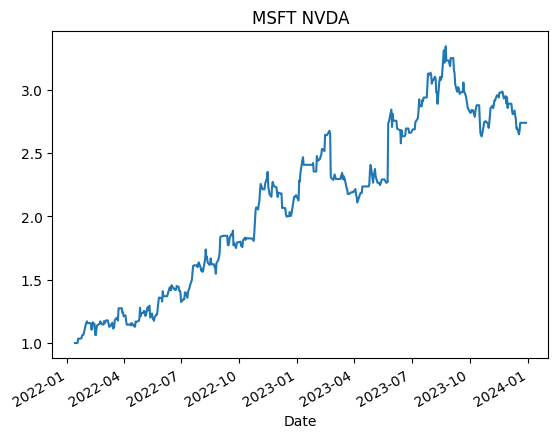

1.7142823867216634

In [25]:
sharpe_ratio(df, stock1, stock2, entry_threshold=overall_best_parameters[0], exit_threshold=overall_best_parameters[1])

# Machine learning for spread prediction
In order to enhance our trading signals, we are going to use machine learning for having a better spread prediction than the moving average we were using before. 

In [27]:
# Define the neural network model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

In [28]:
def sharpe_ratio_ml(df, stock1, stock2, entry_threshold=1, exit_threshold=.5, riskfree_rate=.04, model_type="Moving average", plot_cum_returns=True, test_X=None):
    Y = df[stock1]
    X = df[stock2]
    X_with_constant = sm.add_constant(X)
    model_ols = OLS(Y, X_with_constant).fit() # estimate linear regression coefficients
    spread = Y - model_ols.predict() # get the residuals

    # initialize the daily positions to be zeros
    stock1_position = pd.Series(data=0, index=spread.index)
    stock2_position = pd.Series(data=0, index=spread.index)
    
    spread_preds=[]
    zscores=[]
    
    for i in range(10, len(spread)): # for each day, set up the positions
        
        # Split the data into training and test sets
        if model_type=="svm":
            train_X = np.array(spread[:i-1]).reshape(-1, 1)
            train_y = np.array(spread[1:i])
            svm_model = SVR(kernel='linear')
            svm_model.fit(train_X, train_y)
            spread_pred = svm_model.predict(np.array(spread[i]).reshape(-1,1))[0]
            spread_preds.append(spread_pred)
        elif model_type=="rf":
            train_X = np.array(spread[:i-1]).reshape(-1, 1)
            train_y = np.array(spread[1:i])
            rf_model = RandomForestRegressor(n_estimators=100)
            rf_model.fit(train_X, train_y)
            spread_pred = rf_model.predict(np.array(spread[i]).reshape(-1,1))[0]
            spread_preds.append(spread_pred)
        elif model_type=="nn":
            # Convert data to PyTorch tensors
            train_X_ts = torch.Tensor(spread[:i-1].values).view(-1, 1)
            train_y_ts = torch.Tensor(spread[1:i]).view(-1, 1)

            nn_model = Net()
            # Define the loss function and optimizer
            criterion = nn.MSELoss()
            optimizer = torch.optim.Adam(nn_model.parameters(), lr=0.001)

            # Train the model
            for epoch in range(100):
                optimizer.zero_grad()
                outputs = nn_model(train_X_ts)
                loss = criterion(outputs, train_y_ts)
                loss.backward()
                optimizer.step()

            spread_pred = nn_model(torch.Tensor([spread[i]])).detach().numpy()[0]
            spread_preds.append(spread_pred)  

        else:
            spread_pred=spread[i-10+1:i+1].mean()

        zscore = (spread[i] - spread_pred) /  spread[i-10+1:i+1].std()
        zscores.append(zscore)
        
        if zscore < -entry_threshold and stock1_position.iloc[i-1] == 0: # if zscore<-2 and no existing long position for stock 1, enter the positions:
            stock1_position.iloc[i] = 1 # long stock 1
            stock2_position.iloc[i] = -1 # short stock 2
        elif zscore > entry_threshold and stock2_position.iloc[i-1] == 0: # if zscore>2 and no existing short position for stock 2, enter the positions:
            stock1_position.iloc[i] = -1 # short stock 1
            stock2_position.iloc[i] = 1 # long stock 2
        elif abs(zscore) < exit_threshold: # if -1<zscore<1, close the positions
            stock1_position.iloc[i] = 0
            stock2_position.iloc[i] = 0
        else: # if -2<zscore<-1 or 1<zscore<2, maintain positions
            stock1_position.iloc[i] = stock1_position.iloc[i-1]
            stock2_position.iloc[i] = stock2_position.iloc[i-1]

    # Calculate returns for each stock
    stock1_returns = (Y.pct_change() * stock1_position.shift(1)).fillna(0) # we use shift method because return is calculated using the position at the end of the previous day
    stock2_returns = (X.pct_change() * stock2_position.shift(1)).fillna(0)
    # calculate the total returns of the strategy
    total_returns = stock1_returns + stock2_returns
    if plot_cum_returns:
        cumulative_returns = (1 + total_returns).cumprod()
        # plot the cumulative returns
        cumulative_returns.plot(title=stock1+" "+stock2)
        plt.show()
    
    annualized_return = (1 + total_returns).prod()** (252/Y.shape[0])-1
    # calculate annualized volatility
    annualized_vol = total_returns.std()*(252**0.5)
    if annualized_vol==0:
        annualized_vol = 100
    # calculate Sharpe ratio
    sharpe_ratio = (annualized_return - riskfree_rate) / annualized_vol
    return sharpe_ratio

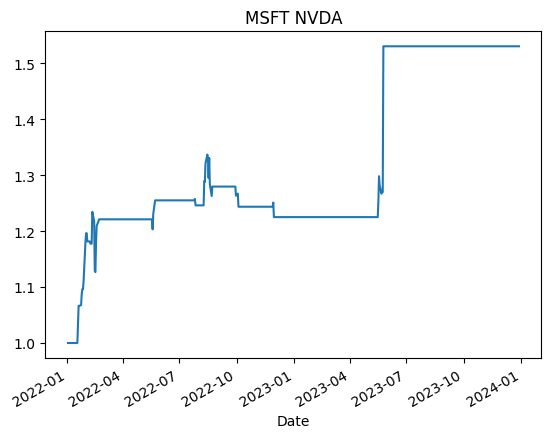

Sharpe ratio SVM:  1.07


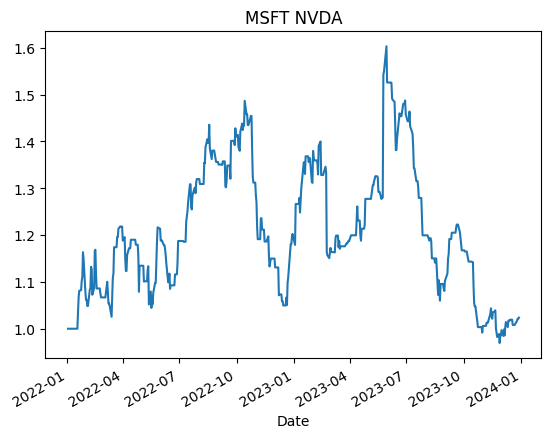

Sharpe ratio RF:  -0.08


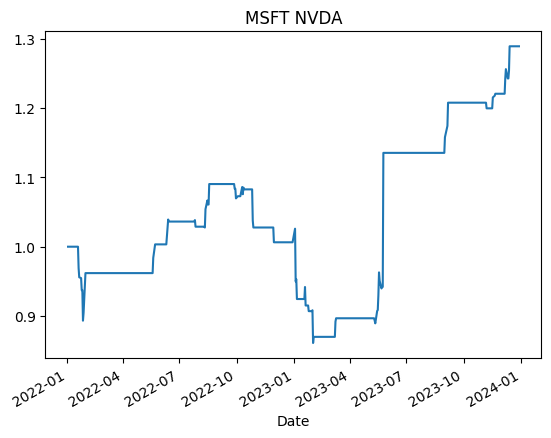

Sharpe ratio NN:  0.5


In [29]:
print("Sharpe ratio SVM: ", round(sharpe_ratio_ml(df, stock1, stock2, entry_threshold=.4, exit_threshold=.3, model_type="svm"),2))
print("Sharpe ratio RF: ", round(sharpe_ratio_ml(df, stock1, stock2, entry_threshold=.4, exit_threshold=.3, model_type="rf"),2))
print("Sharpe ratio NN: ", round(sharpe_ratio_ml(df, stock1, stock2, entry_threshold=.4, exit_threshold=.3, model_type="nn"),2))

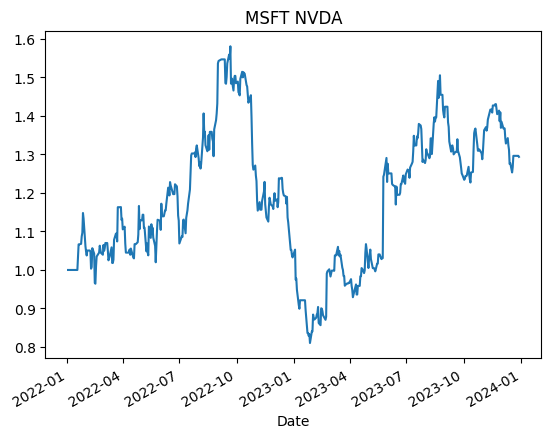

0.25328700816039496

In [30]:
sharpe_ratio_ml(df, stock1, stock2, entry_threshold=.4, exit_threshold=.3, model_type="ma")

## References
This notebook is based on the work of Peng Liu in the chapter 8 of his book: Quantitative Trading Strategies Using Python.

The work is still in progress.